**PREDICTING SOVEREIGN DEFAULTS: A COMPARATIVE APPROACH USING LOGISTIC REGRESSION AND KNN**

In this, project, I compare how logistic regression and K-nearest-neighbors (KNN) models perform in forecasting sovereign defaults. A sovereign default is any instance where a country fails to re-pay its contracted debt.

I used a compilation of data from the IMF and the World Bank with some modifications. The chosen independent variables are:

1. Current account balance as % of GDP
2. Total reserves as % of foreign debt
3. Total government debt as % of GDP

**METHODOLOGY**

Using the 'default_dummy' excel file, I created a binary classification on whether a default occurred (1) or not (0) for each country and year. If a country had any amount of debt on default, it receives Classification 1. 

I then proceeded to identify when the positive and negative cases were more evenly distributed in the most up-do-date statistics, which ended up being 2019. A full account of positive/negative distributions per year can be found on the file. 

In [54]:
#Importing first packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
#Loading and datasets
debt_stats = pd.read_excel('debt_stats_mod.xlsx', na_values ='..')
debt_stats.head()

default_dummy = pd.read_excel('default_dummy.xlsx', sheet_name = 'DefaultCount2019')
default_dummy.head()

,Unnamed: 0,2019
0,Afghanistan,0
1,Albania,0
2,Algeria,0
3,Angola,0
4,Antigua and Barbuda,1


**Modifying the dependent variable's dataset**

Explain what you did

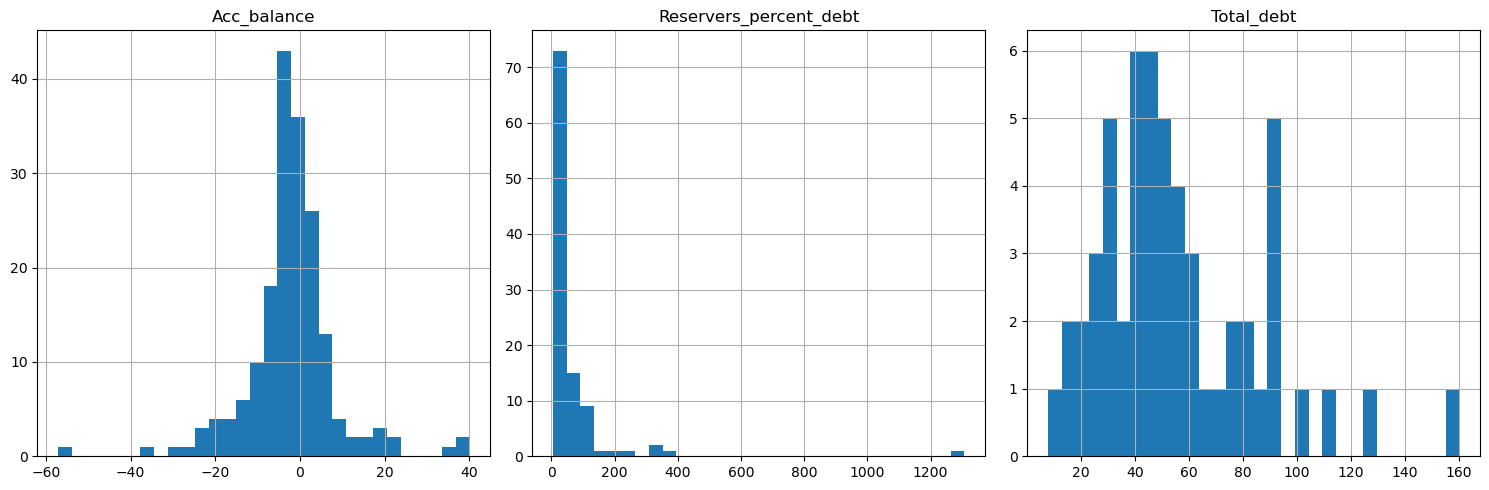

In [56]:
#Selecting only necessary columns
debt_stats = debt_stats[['Country Name','Acc_balance',
'Reservers_percent_debt','Total_debt']]

#Checking distribution of each variable
debt_stats.hist(bins=30, figsize=(15, 5), layout=(1, 3))
plt.tight_layout() 
plt.show()

..

Acc_balance looks well distributed, but reserves_percent_debt and total_debt are quite skewed. This means that it will be better to use the median in order to replace missing values in those two columns.

Let's do that.


In [57]:
#Values to fill according to each columns distribution
fill_values = {
    'Acc_balance': debt_stats['Acc_balance'].mean(),
    'Reservers_percent_debt': debt_stats['Reservers_percent_debt'].median(),
    'Total_debt': debt_stats['Total_debt'].median()
}

debt_stats_filled = debt_stats.fillna(value=fill_values)

**Merging datasets**

Here we do this by country. We should have the complete dataset ready to run the models.

Since not every country had all the data available for the same period of time, I had to include only those that had complete statistics for defauls, account balances and debt.

In [58]:
#Modifying column names to facilitate an inner joint
default_dummy = default_dummy.rename(columns={'Unnamed: 0': 'Country'})
debt_stats_filled = debt_stats_filled.rename(columns={'Country Name': 'Country'})

#Merging datasets
merged_df = pd.merge(
    default_dummy,
    debt_stats_filled,
    on='Country',
    how='inner'
)

#Correcting the '2019' name
merged_df.rename(columns={2019: 'Default'}, inplace=True)
merged_df.tail()

,Country,Default,Acc_balance,Reservers_percent_debt,Total_debt
124,Uzbekistan,0,-5.009722,127.588826,50.028421
125,Vanuatu,0,7.825806,120.442469,50.028421
126,West Bank and Gaza,1,-10.385480,36.177682,50.028421
127,Yemen,1,-2.136843,23.438584,50.028421
128,Zambia,0,0.603691,4.928556,61.930117


**Performing Logistic Regression Analysis**

Now that we have the full dataset, we can start running the models. I'll start with the Logistic Regression Model

In [59]:
#Separating training and fitting sets
from sklearn.model_selection import train_test_split

X = merged_df[['Acc_balance','Reservers_percent_debt','Total_debt']]
y = merged_df['Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

#Fitting the model
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

#Testing the model and cheking results
predictions = logmodel.predict(X_test)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85        29
           1       0.00      0.00      0.00        10

    accuracy                           0.74        39
   macro avg       0.37      0.50      0.43        39
weighted avg       0.55      0.74      0.63        39

[[29  0]
 [10  0]]


C:\Users\Vinicius\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Vinicius\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Vinicius\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Results on precision, recall and f1 look good but I want to focus on the confusion matrix.

The model is good at predicting non-defaults (23 out of 26) but is flawed in predicting actual defaults (1 out of 13) which is our whole objective. 

More importantly, the likelihood of committing a Type I error (predicting a non-default when the actual occurrence is a default) is 92% which is not at all good from a country risk management perspective. Let's see if the KNN model does it better.

**Performing KNN analysis**

In [60]:
## Step 1: Standardizing Values
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(merged_df.drop(['Default','Country'],axis=1)) #only predictor variables included, excluding text values for country
scaled_feat = scaler.transform(merged_df.drop(['Default','Country'],axis=1)) #only predictor variables included, excluding text values for country
scaled_feat

scaled_dataset = pd.DataFrame(scaled_feat, columns = merged_df.columns[2:5]) #gives the original names excluding target class
scaled_dataset.head()

#Step 2: Separating Train and Test sets
from sklearn.model_selection import train_test_split 

X = scaled_dataset
y = merged_df['Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

#Step 3: Fitting the KNN Model and making predictions
from sklearn.neighbors import KNeighborsClassifier 

knn = KNeighborsClassifier(n_neighbors = 1)

knn.fit(X_train, y_train)

predictions = knn.predict(X_test)

#Step 4: Cheching Confusion Matrix and Classification Report (the model's accuracy)
from sklearn.metrics import classification_report,confusion_matrix 

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions)) 

[[20 15]
 [ 5  3]]
              precision    recall  f1-score   support

           0       0.80      0.57      0.67        35
           1       0.17      0.38      0.23         8

    accuracy                           0.53        43
   macro avg       0.48      0.47      0.45        43
weighted avg       0.68      0.53      0.59        43



The results continue to be very poor. The accuracy is no better than a coin flip in predicting defaults!

I will now check if we can use an optimal number of k-neighbors to improve it. 

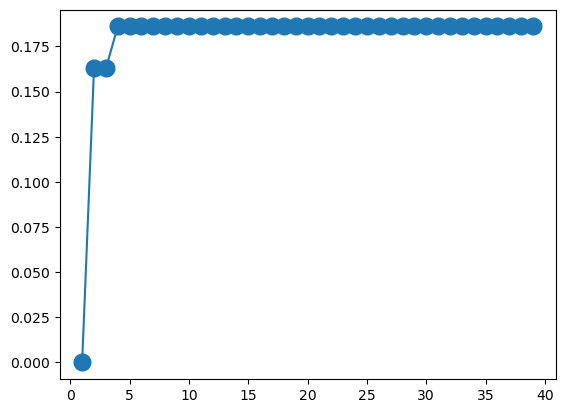

In [61]:
#Choosing a K value that improves accuracy
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_test,y_test)
    pred_model = knn.predict(X_test)
    error_rate.append(np.mean(pred_model != y_test))

#Visually checking the behavior of accurary as K increases
plt.plot(range(1,40), error_rate, marker = 'o', markersize = 12)
plt.show()

It looks like the error rate will only increase if we try to increase the value of K. The model suffers from a severe limitation in terms of predictions.

**Conclusions**

Both models performed poorly in forecasting sovereign defaults.

This is likely due to variable selection. While it's true that sovereign defaults are in a way influenced by the chosen metrics, other factors, including non-quantitative ones related to ideology and domestic politics, 
